In [1]:
import nibabel as nib
from nibabel import processing

from skimage import io
from skimage.transform import resize
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np
import os
import glob
import warnings
import shutil

import SimpleITK as sitk
# from nipype.interfaces.ants import N4BiasFieldCorrection
from scipy import misc

from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
import argparse
from pathlib import Path
import re
import PIL
import cv2
from torchvision.transforms import v2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
from PIL import Image, ImageDraw
import pandas as pd
import seaborn as sns

In [83]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [2]:
scan_slices_train_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/train/scan/")
endo_mask_slices_train_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/train/endo_mask/")
epi_mask_slices_train_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/train/epi_mask/")

scan_slices_valid_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/valid/scan/")
endo_mask_slices_valid_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/valid/endo_mask/")
epi_mask_slices_valid_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/valid/epi_mask/")

scan_slices_valid_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/test/scan/")
endo_mask_slices_valid_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/test/endo_mask/")
epi_mask_slices_valid_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/test/epi_mask/")

In [3]:
# have a look at data for sanity check 

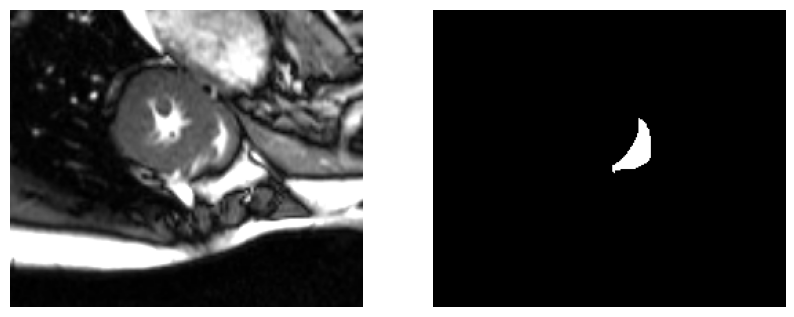

In [4]:
test_num = 45
test_scan = os.path.join(scan_slices_train_dir, f"scan_{test_num}.png")
test_mask = os.path.join(endo_mask_slices_train_dir, f"mask_{test_num}.png")
data_scan = PIL.Image.open(test_scan)
data_scan_arr = np.array(data_scan)

data_mask = PIL.Image.open(test_mask)
data_mask_arr = np.array(data_mask)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(data_scan_arr, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(data_mask_arr, cmap=plt.cm.gray)

In [5]:
data_root_folder = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data") # change this line to run on different data
# Path('C:/Users/Susanna/Documents/Heart_Segmentation/data/')

In [13]:
data_root_folder = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data")
class BasicDataset(TensorDataset):
    # retrieve files from folder 
    def __init__(self, folder, mask_type, n_sample=None, transform=None):
        self.folder = os.path.join(data_root_folder, folder)
        self.imgs_dir = os.path.join(self.folder, 'scan')
        self.masks_dir = os.path.join(self.folder, f'{mask_type}_mask')
        self.imgs_file = sorted(glob.glob(os.path.join(self.imgs_dir, '*.png')))
        self.masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*.png')))
        
        assert len(self.imgs_file) == len(self.masks_file), 'There are some missing images or masks in {0}'.format(folder)
        
        # If n_sample is not None (It has been set by the user)
        if not n_sample or n_sample > len(self.imgs_file):
            n_sample = len(self.imgs_file)
        
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
        self.transform = transform
            
    # Return length of dataset
    def __len__(self):
        return self.n_sample
    
    
        # return scan, corresponding mask, and the file index 
    def __getitem__(self, i):
        idx = self.ids[i]
        
        img = cv2.imread(os.path.join(self.imgs_dir, 'scan_{:}.png'.format(idx)), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.masks_dir, 'mask_{:}.png'.format(idx)), cv2.IMREAD_GRAYSCALE)

        img = np.array(img) / 255.0
        mask = np.array(mask) / 255.0

        mask[mask <= 0.5] = 0.0
        mask[mask > 0.5] = 1.0        

        # data augmentation
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # resive from 512x216
        img = cv2.resize(img, (128,128))
        mask = cv2.resize(mask, (128,128))
        
        # Add an axis to the mask array so that it is in [channel, width, height] format.
        mask = np.expand_dims(mask, axis=0)
        img = np.expand_dims(img, axis=0)
        
        img = img.copy()
        mask = mask.copy()
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor),
            'img_id': idx
        }

In [14]:
# image transformations 
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
], is_check_shapes=False)

In [15]:
# Create train, validation, and test dataset instances - RV segmentation 
train_dataset = BasicDataset('train', 'epi', transform=transforms)
valid_dataset = BasicDataset('valid', 'epi', transform=transforms)
test_dataset = BasicDataset('test', 'epi', transform=transforms)

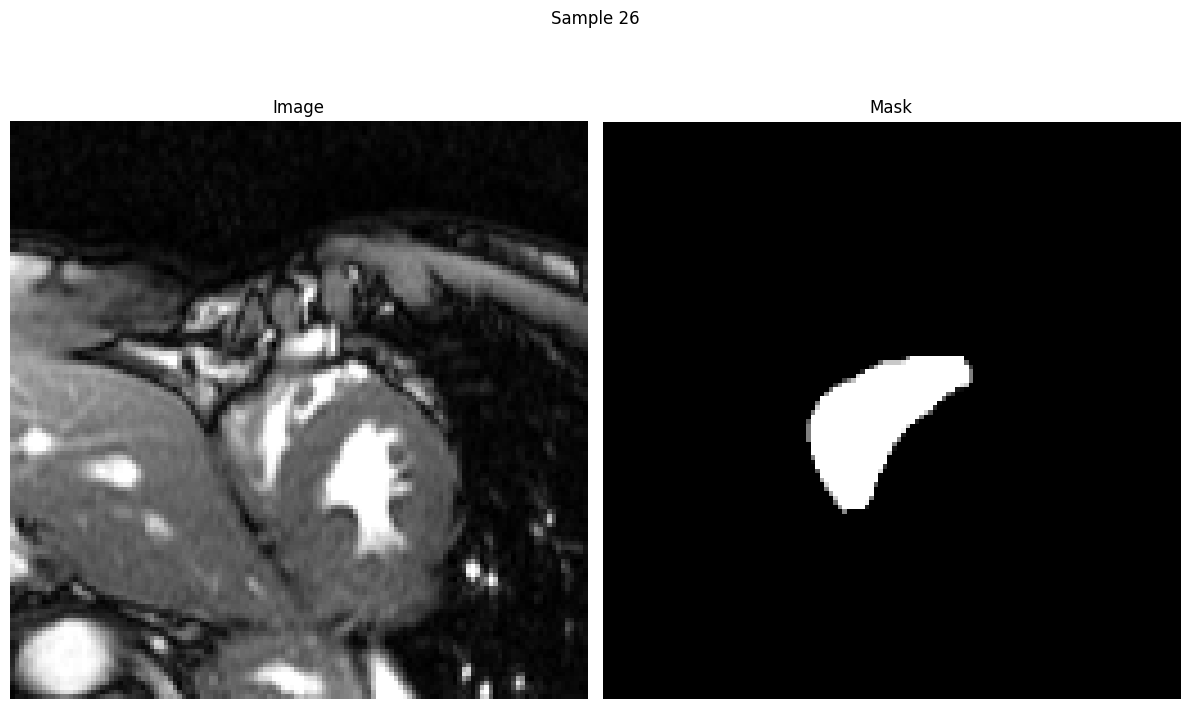

In [16]:
# visualize a scan and corresponding mask for sanity check 
sample = np.random.randint(0, len(train_dataset))
data = train_dataset.__getitem__(sample)
x = data['image']
y = data['mask']
idx = data['img_id']

plt.figure(figsize=(12, 8), dpi=100)
plt.suptitle(f'Sample {idx}')
img = x[0]
mask = y[0]
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img,  cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, num_workers=0, pin_memory=True)

In [ ]:
############################################## Standard U-Net #################################################################

In [27]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)

In [28]:
class UNet(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
    def forward(self, x):
        x0 = self.inputL(x)
        
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.up4(x, x0)
        
        x = self.outputL(x)
        
        return x

In [29]:
myocard_UNet = UNet('MyUNet', n_channels=1, n_classes=1)
myocard_UNet.cuda()

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

In [52]:
# load pre trained weights
model_path = Path("C:\\Users\\Susanna\\Documents\\stored_models\\2d_unet.pth")
myocard_UNet.load_state_dict(torch.load(model_path))
myocard_UNet.eval()

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

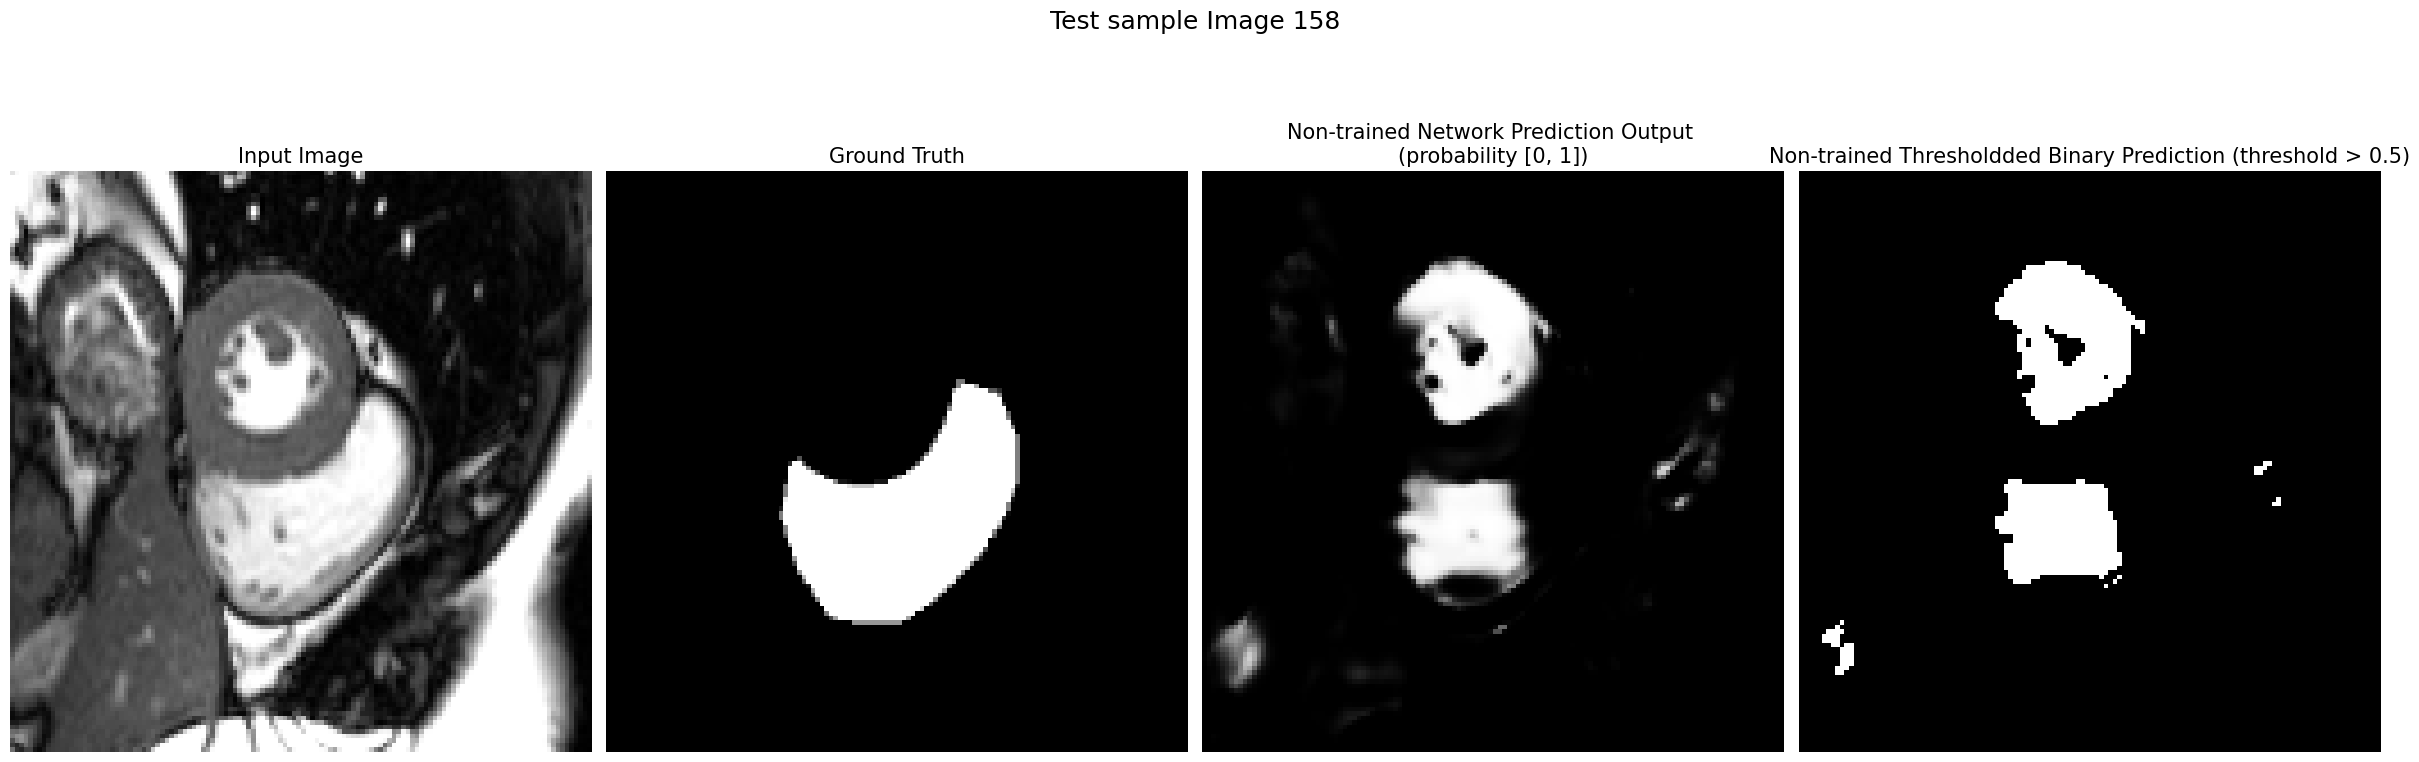

In [57]:
# Visualize pre-trained model
for batch in train_dataloader:
    sample_batch = batch
    break
    
# Generat network prediction
with torch.no_grad():
    y_pred = myocard_UNet(sample_batch['image'].cuda())

img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')

pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

plt.figure(figsize=(24,9))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img,cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Non-trained Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Non-trained Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [58]:
optimizer = torch.optim.Adam(myocard_UNet.parameters(), lr=0.001) # using Adam optimizer with learning rate of 0.001
loss_function = nn.BCELoss() # using binary cross entropy loss 

In [59]:
# Define a function that computes the DICE score for binary segmentation
def dice_coeff_binary(y_pred, y_true):
    """Values must be only zero or one."""
    eps = 0.0001
    inter = torch.dot(y_pred.view(-1), y_true.view(-1))
    union = torch.sum(y_pred) + torch.sum(y_true)
    return ((2 * inter.float() + eps) / (union.float() + eps)).cpu().numpy()

In [60]:
# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    
    for epoch in range(epochs):
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        
        for i, batch in enumerate(train_dataloader):
            # Load a batch 
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            # Produce the estimated mask from model
            y_pred = net(imgs)

            # Compute the loss for the batch
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                   
            
            # Compute the DICE score for batch 
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            
            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)

        # validation 
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        
        # set layers to evaluation mode
        # don't need to calculate the gradient 
        # speeds up evaluation 
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                y_pred = net(imgs)

                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                pred_binary = (y_pred > 0.5).float()                    

                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}')
    
    return train_loss, train_dice, valid_loss, valid_dice

In [62]:
EPOCHS = 30 # trained for different amounts of epochs, generally needs around 70 epochs
train_loss, train_dice, valid_loss, valid_dice = train_net(myocard_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

EPOCH 1/30 - Training Loss: 0.042473931157265804, Training DICE score: 0.8367065787315369, Validation Loss: 0.051090491858000554, Validation DICE score: 0.7136074900627136
EPOCH 2/30 - Training Loss: 0.04098435531718185, Training DICE score: 0.8404294848442078, Validation Loss: 0.05465984010758499, Validation DICE score: 0.7301914095878601
EPOCH 3/30 - Training Loss: 0.03448352895407791, Training DICE score: 0.8781985640525818, Validation Loss: 0.05221625316577653, Validation DICE score: 0.7317953705787659
EPOCH 4/30 - Training Loss: 0.03186028859162905, Training DICE score: 0.8844126462936401, Validation Loss: 0.03495995048433542, Validation DICE score: 0.7570290565490723
EPOCH 5/30 - Training Loss: 0.028988842336258973, Training DICE score: 0.8901464343070984, Validation Loss: 0.04321817044789592, Validation DICE score: 0.741546630859375
EPOCH 6/30 - Training Loss: 0.02708777364522937, Training DICE score: 0.8913533091545105, Validation Loss: 0.05533205911827584, Validation DICE scor

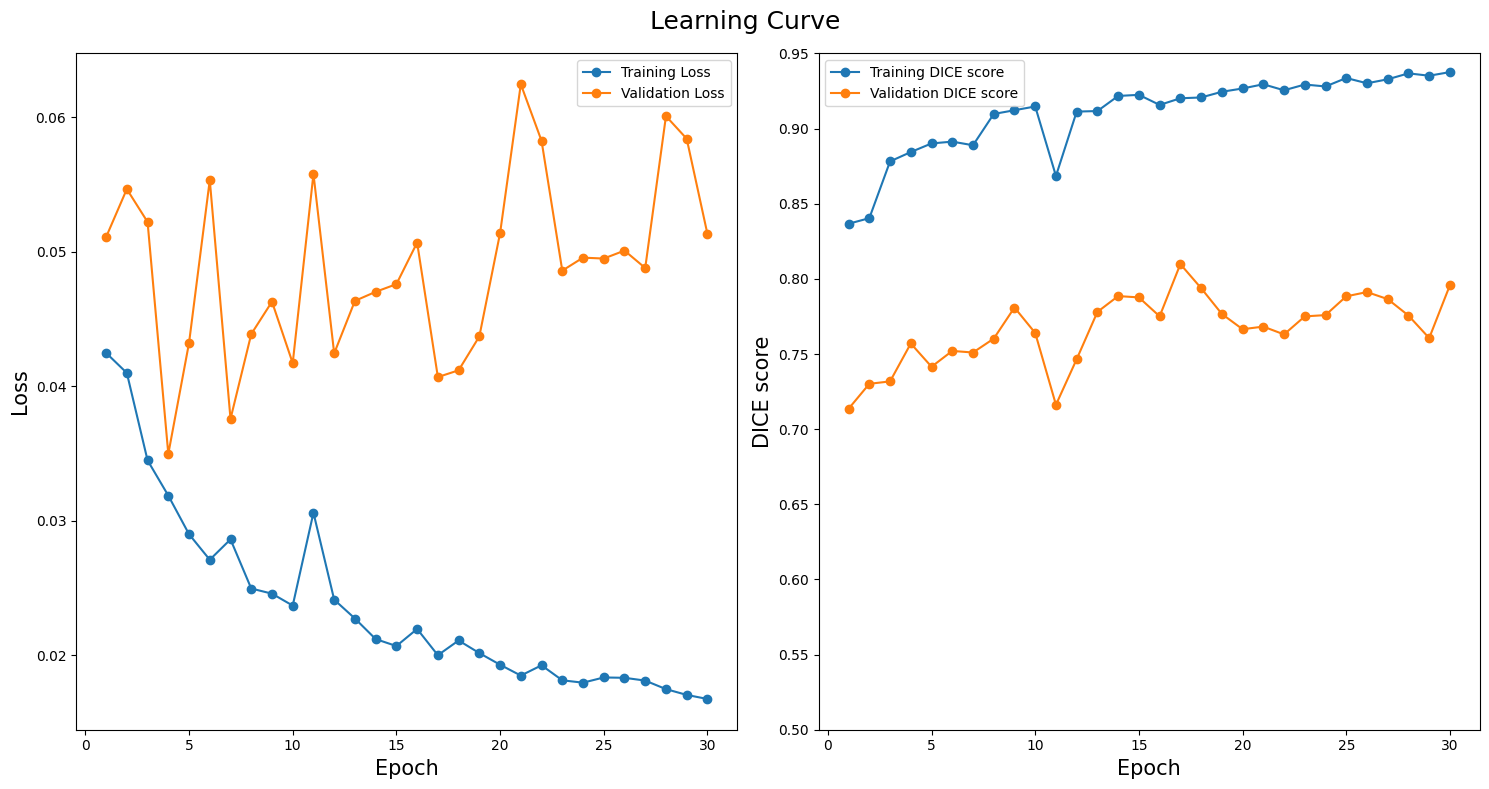

In [66]:
plt.figure(figsize=(15,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,2,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
#plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.ylim(0.5,0.95)
#plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

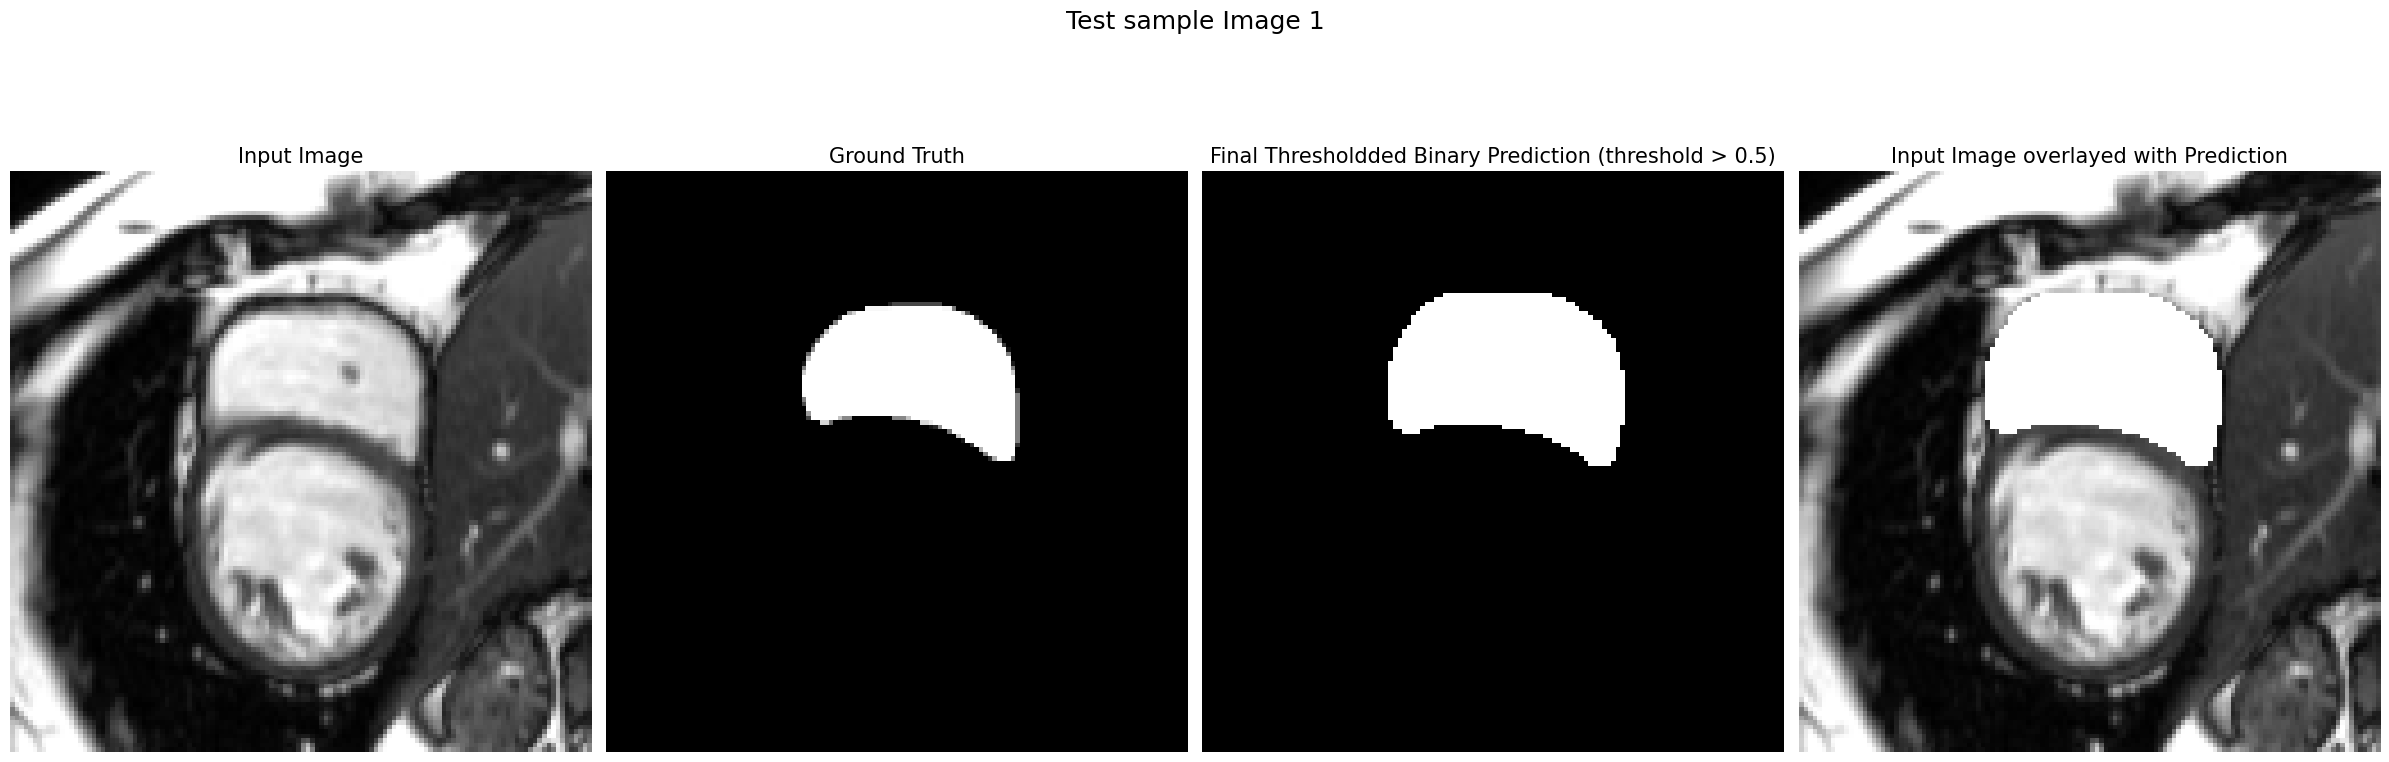

In [67]:
# Take the first batch
batches = []
test_num = 0

for batch in test_dataloader:
    sample_batch = batch
    batches.append(batch)

sample_batch = batches[0] 

# Generate network prediction
with torch.no_grad():
    y_pred = myocard_UNet(sample_batch['image'].cuda())


test_num = 1 #0 #1
# Conver Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][test_num].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][test_num][0,:,:].numpy() * 255).astype('uint8')

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[test_num][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[test_num][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

plt.figure(figsize=(24,9))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Final Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred[pred_msk_binary == 255] = [255] 
plt.subplot(1,4,4)
plt.title('Input Image overlayed with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [68]:
# store test data predictions in array 
masks_test = []
for batch in batches: 
    with torch.no_grad():
        y_pred = myocard_UNet(batch['image'].cuda())
    for i in range(4): 
        pred_msk = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

        masks_test.append(pred_msk)

In [47]:
# store test data predictions as files 
def store_outputs(masks, store_dir):
    ind = 0
    for i in range(len(masks)): # loop that goes through 3D imgs
        im_to_save = Image.fromarray(masks[i])
        if im_to_save.mode != 'RGB':
            im_to_save = im_to_save.convert('RGB')
        file_name = f"mask_{ind+1}.png"
        mask_dir = os.path.join(store_dir, "_masks")
        im_to_save.save(os.path.join(store_dir, file_name))
        ind += 1

In [47]:
# helper function to get mask from folder 
def get_mask(ind, folder): 
    mask_file = os.path.join(folder, f"mask_{ind+1}.png")
    mask_img = PIL.Image.open(mask_file)
    mask_arr = np.array(mask_img)
    return mask_arr, mask_img, mask_file

# helper function to get img from folder 
def get_img(ind, folder): 
    mask_file = os.path.join(folder, f"scan_{ind+1}.png")
    mask_img = PIL.Image.open(mask_file)
    mask_arr = np.array(mask_img)
    return mask_arr, mask_img, mask_file

# helper function to get contour from folder
def get_contour(ind, folder): 
    mask_file = os.path.join(folder, f"contour_{ind+1}.png")
    mask_img = PIL.Image.open(mask_file)
    mask_arr = np.array(mask_img)
    return mask_arr, mask_img, mask_file

# atore contours generated from mask
def store_contours(masks, masks_dir, store_dir):
    for i in range(len(masks)):
        mask_arr, mask_img, mask_file = get_mask(i, masks_dir)
        contour = cv2.imread(mask_file)
        contour_gray = cv2.cvtColor(contour,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(contour_gray,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        tmp = np.zeros_like(contour)
        boundary = cv2.drawContours(tmp, contours, -1, (255,255,255), 1)
        boundary[boundary > 0] = 255
        file_name_contour = f"contour_{i+1}.png"
        plt.imsave(os.path.join(store_dir, file_name_contour), boundary, cmap = "gray")

In [49]:
output_dir_unet = Path("C:/Users/Susanna/Documents/myocardium_segmentation/outputs/u_net/epicardium/masks_augment")
output_dir_attn = Path("C:/Users/Susanna/Documents/myocardium_segmentation/outputs/attention_u_net/epicardium/masks_augment")

contours_unet =  Path("C:/Users/Susanna/Documents/myocardium_segmentation/outputs/u_net/epicardium/contours_augment")
contours_attn = Path("C:/Users/Susanna/Documents/myocardium_segmentation/outputs/attention_u_net/epicardium/contours_augment")

img_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/test/scan/")
gt_dir = Path("C:/Users/Susanna/Documents/myocardium_segmentation/data/test/epi_mask/")

In [316]:
store_outputs(masks_test, output_dir_unet)

In [317]:
store_contours(masks_test, output_dir_unet, contours_unet)

In [46]:
def test_net(net, test_dataloader, loss_function):
    # Create the pred_mask folder
    
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = list()
    test_batch_dice = list()
    test_batch_accuray = list()
    test_batch_CM = list()

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            img_ids = batch['img_id'].numpy().astype('int')

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            test_batch_dice.append(batch_dice_score)
     
    test_dice = np.array(test_batch_dice).mean()

    return  test_dice 

In [47]:
test_dice= test_net(myocard_UNet, test_dataloader, loss_function)

print(f' Test DICE score: {test_dice}')

 Test DICE score: 0.24613641202449799


In [96]:
############################################################# Attention U-Net ############################################################

In [106]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
          nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1,padding=1, bias=True),
          nn.BatchNorm2d(ch_out),
          nn.ReLU(inplace=True),
          nn.Conv2d(ch_out, ch_out,kernel_size=3, stride=1, padding=1, bias=True),
          nn.BatchNorm2d(ch_out),
          nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x  

In [107]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(nn.Upsample(scale_factor=2),nn.Conv2d(ch_in, ch_out,kernel_size=3,stride=1,padding=1, bias=True),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.up(x)
        return x

In [108]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        # gating signal weights
        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True), 
            nn.BatchNorm2d(f_int)
        )
        # input feature scaling
        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(f_int)
        )

        # output of attention gate 
        self.psi = nn.Sequential(nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0,  bias=True),
        nn.BatchNorm2d(1),
        nn.Sigmoid(),
        )
        self.relu = nn.ReLU(inplace=True)

    # implementing the attention gate 
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

In [109]:
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=1, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)



    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

In [110]:
attention_unet_myocard = AttentionUNet(n_classes=1).to(device)

In [111]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

In [114]:
attention_unet_myocard.load_state_dict(torch.load('model_weights_attention_net.pth')) # attention_unet.pth
attention_unet_myocard.eval()

AttentionUNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)

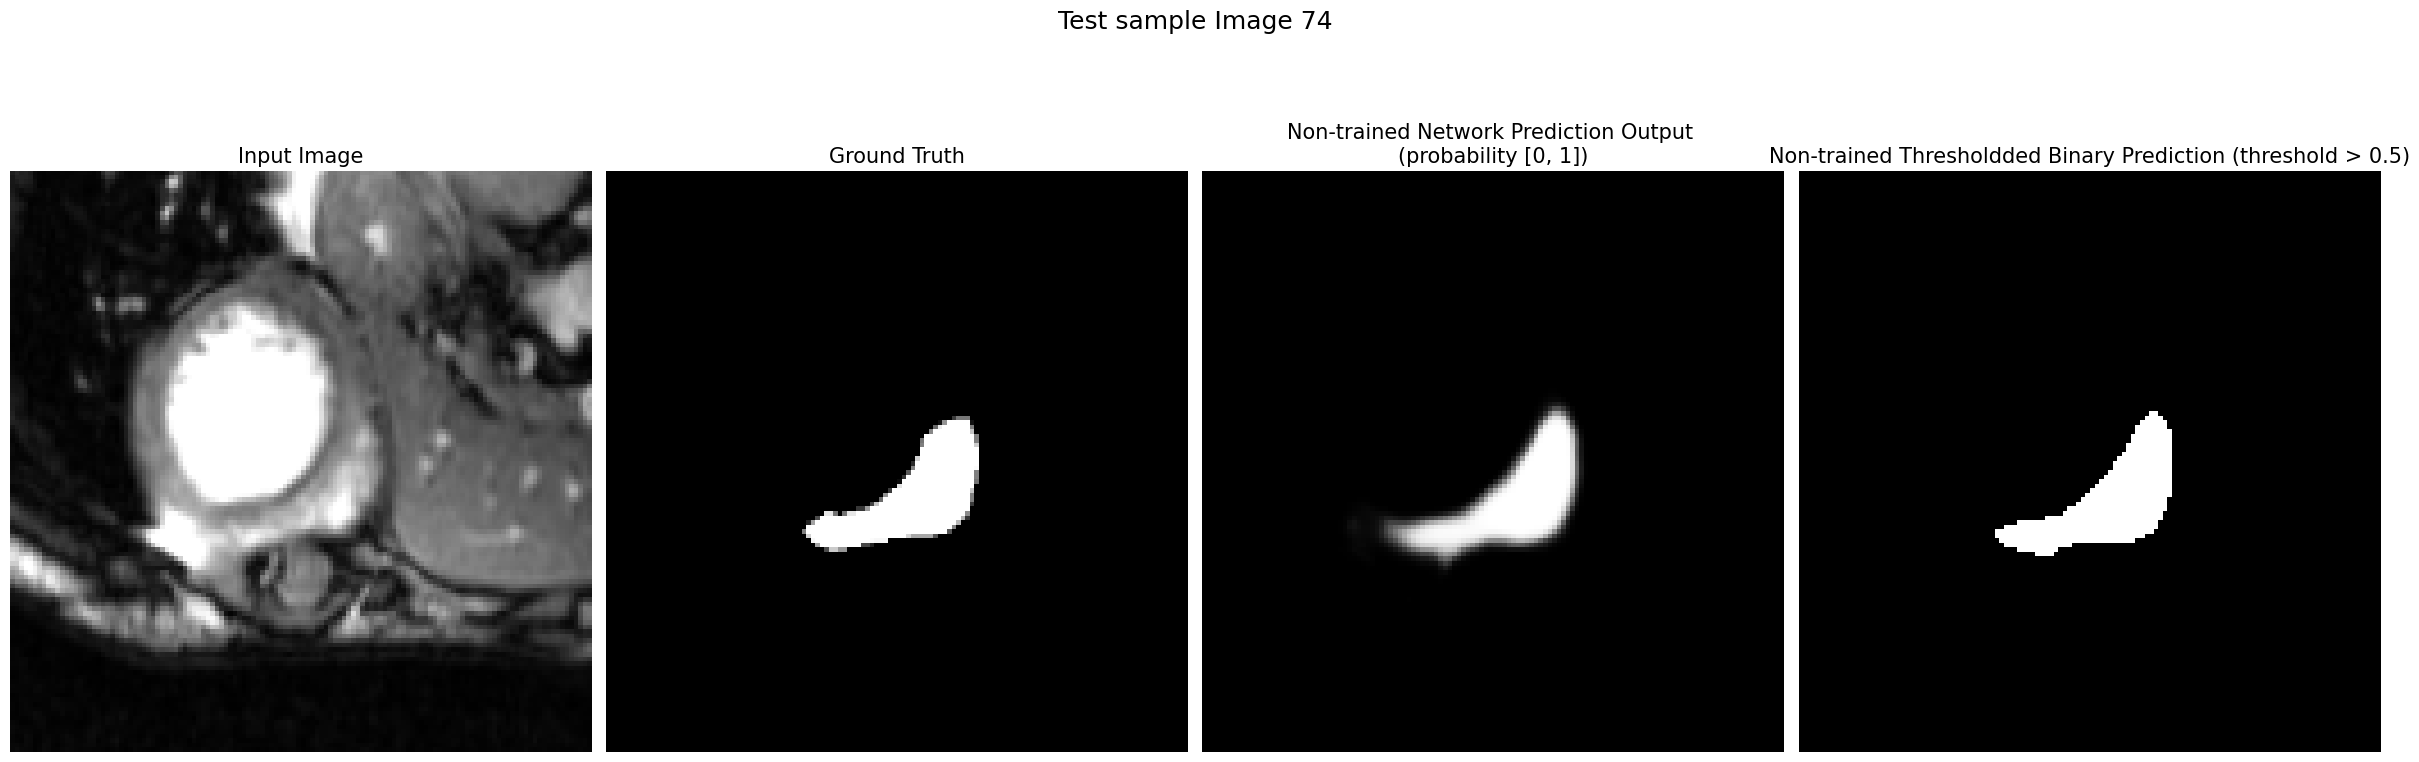

In [116]:
# show prediciton with pre trained wiehgts
for batch in train_dataloader:
    sample_batch = batch
    break


# Generat network prediction
with torch.no_grad():
    y_pred = myocard_UNet(sample_batch['image'].cuda())

img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')

pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

plt.figure(figsize=(24,9))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img,cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Non-trained Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Non-trained Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [123]:
def compute_dice(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, batch in enumerate(loader):
            
            data = batch['image'].cuda()
            target = batch['mask'].cuda()
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [124]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i_step, batch in enumerate(tqdm(train_loader)):
            
            data = batch['image'].cuda()
            target = batch['mask'].cuda()
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_mean_iou = compute_dice(model, val_loader)
        val_loss = train_loss(outputs, target)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        val_loss_history.append(val_loss.item())
        
        print("Epoch [%d]" % (epoch+1))
        print("Training loss :", np.array(losses).mean(), 
              "DICE score training:", np.array(train_iou).mean(), 
              "DICE score validation", val_mean_iou,
              "Validation loss:", np.array(val_loss_history).mean())
        
    return loss_history, train_history, val_history, val_loss_history
    

In [125]:
opt = torch.optim.Adamax(attention_unet_myocard.parameters(), lr=1e-3) # use Adam optimizer 
loss_function = nn.BCELoss() # use BCE loss 

In [126]:
%%time
num_ep = 30

aun_lh, aun_th, aun_vh, aun_vl = train_model("Attention UNet", attention_unet_myocard, train_dataloader, valid_dataloader, loss_function, opt, False, num_ep)

100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 19.65it/s]


Epoch [1]
Training loss : 0.19512442795627088 DICE score training: 0.8050580792769161 DICE score validation 0.7024760887976514 Validation loss: 0.07059663534164429


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 20.41it/s]


Epoch [2]
Training loss : 0.14460011849920434 DICE score training: 0.8555053145205487 DICE score validation 0.7467671147675528 Validation loss: 0.08654561638832092


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 20.40it/s]


Epoch [3]
Training loss : 0.15347735781267466 DICE score training: 0.8469146284750603 DICE score validation 0.7615216169099306 Validation loss: 0.08829708894093831


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 20.58it/s]


Epoch [4]
Training loss : 0.11725819254496012 DICE score training: 0.8829627850726893 DICE score validation 0.7796270793104909 Validation loss: 0.10936403274536133


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 20.46it/s]


Epoch [5]
Training loss : 0.10373966521527393 DICE score training: 0.8963879127581028 DICE score validation 0.7696923927100588 Validation loss: 0.11152527332305909


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 13.77it/s]


Epoch [6]
Training loss : 0.1101633166692343 DICE score training: 0.8900877590219225 DICE score validation 0.7541265571805396 Validation loss: 0.11250366767247517


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.14it/s]


Epoch [7]
Training loss : 0.10497259231935065 DICE score training: 0.8951327324261311 DICE score validation 0.7848048612831766 Validation loss: 0.10842333521161761


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 20.97it/s]


Epoch [8]
Training loss : 0.10004253847053252 DICE score training: 0.9003288595297015 DICE score validation 0.7774998835377009 Validation loss: 0.11424869298934937


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.02it/s]


Epoch [9]
Training loss : 0.09935258239148612 DICE score training: 0.9007556983543344 DICE score validation 0.7997396720110508 Validation loss: 0.12328009472952949


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.17it/s]


Epoch [10]
Training loss : 0.09286285380283034 DICE score training: 0.9073036281672042 DICE score validation 0.7867128560483947 Validation loss: 0.1235491931438446


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.38it/s]


Epoch [11]
Training loss : 0.08952611541173544 DICE score training: 0.9106635308438273 DICE score validation 0.8050034758633389 Validation loss: 0.11747628992254083


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.44it/s]


Epoch [12]
Training loss : 0.08377952604408724 DICE score training: 0.9162501121416444 DICE score validation 0.7949276090896483 Validation loss: 0.11902825037638347


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.05it/s]


Epoch [13]
Training loss : 0.08289461897080203 DICE score training: 0.9172551604866135 DICE score validation 0.7781468103151568 Validation loss: 0.11455240616431603


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.15it/s]


Epoch [14]
Training loss : 0.08649993948189609 DICE score training: 0.9137012074282719 DICE score validation 0.7839625192127173 Validation loss: 0.10992825882775444


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.44it/s]


Epoch [15]
Training loss : 0.0905371904373169 DICE score training: 0.9096294300171116 DICE score validation 0.7935288605724835 Validation loss: 0.10673038562138876


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.12it/s]


Epoch [16]
Training loss : 0.09163213925189283 DICE score training: 0.9085097052694269 DICE score validation 0.8205954985734097 Validation loss: 0.10371529310941696


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.28it/s]


Epoch [17]
Training loss : 0.0814218348767384 DICE score training: 0.9187599563479024 DICE score validation 0.795115329507411 Validation loss: 0.10216638621161966


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.10it/s]


Epoch [18]
Training loss : 0.07266269390841565 DICE score training: 0.927555437597751 DICE score validation 0.8054701890060901 Validation loss: 0.09911929236518012


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.27it/s]


Epoch [19]
Training loss : 0.086827794471419 DICE score training: 0.9133564700625075 DICE score validation 0.79136393791648 Validation loss: 0.10413905507639835


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.39it/s]


Epoch [20]
Training loss : 0.08402264333633055 DICE score training: 0.915992200364025 DICE score validation 0.8128987516184315 Validation loss: 0.10318425595760346


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.13it/s]


Epoch [21]
Training loss : 0.08067723713725446 DICE score training: 0.9195656888624184 DICE score validation 0.7810852609834601 Validation loss: 0.1019861414318993


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.09it/s]


Epoch [22]
Training loss : 0.08462484773383083 DICE score training: 0.915565005860485 DICE score validation 0.7968222485041432 Validation loss: 0.09968326308510521


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.19it/s]


Epoch [23]
Training loss : 0.0848946248192385 DICE score training: 0.9153305244552156 DICE score validation 0.8088620019021249 Validation loss: 0.09729622498802516


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.30it/s]


Epoch [24]
Training loss : 0.06916057560817306 DICE score training: 0.9308318666344143 DICE score validation 0.7768244153006821 Validation loss: 0.09720408916473389


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.72it/s]


Epoch [25]
Training loss : 0.07922738216009485 DICE score training: 0.9209272072227729 DICE score validation 0.8097122269725225 Validation loss: 0.09668884992599487


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.15it/s]


Epoch [26]
Training loss : 0.07597320553768112 DICE score training: 0.9242127159726267 DICE score validation 0.7985709639849946 Validation loss: 0.09544472510998066


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.74it/s]


Epoch [27]
Training loss : 0.06990054716546852 DICE score training: 0.9303256636414062 DICE score validation 0.8209556605446109 Validation loss: 0.0944723266142386


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.47it/s]


Epoch [28]
Training loss : 0.06954011428787048 DICE score training: 0.9306609446031504 DICE score validation 0.8063575900605514 Validation loss: 0.09376485220023564


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.46it/s]


Epoch [29]
Training loss : 0.07533896615706294 DICE score training: 0.9247501177361986 DICE score validation 0.8037843530085647 Validation loss: 0.09299730432444606


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 21.22it/s]


Epoch [30]
Training loss : 0.07128967793591051 DICE score training: 0.9289203547457668 DICE score validation 0.7972857112566495 Validation loss: 0.09111266136169434
CPU times: total: 2min 8s
Wall time: 2min 12s


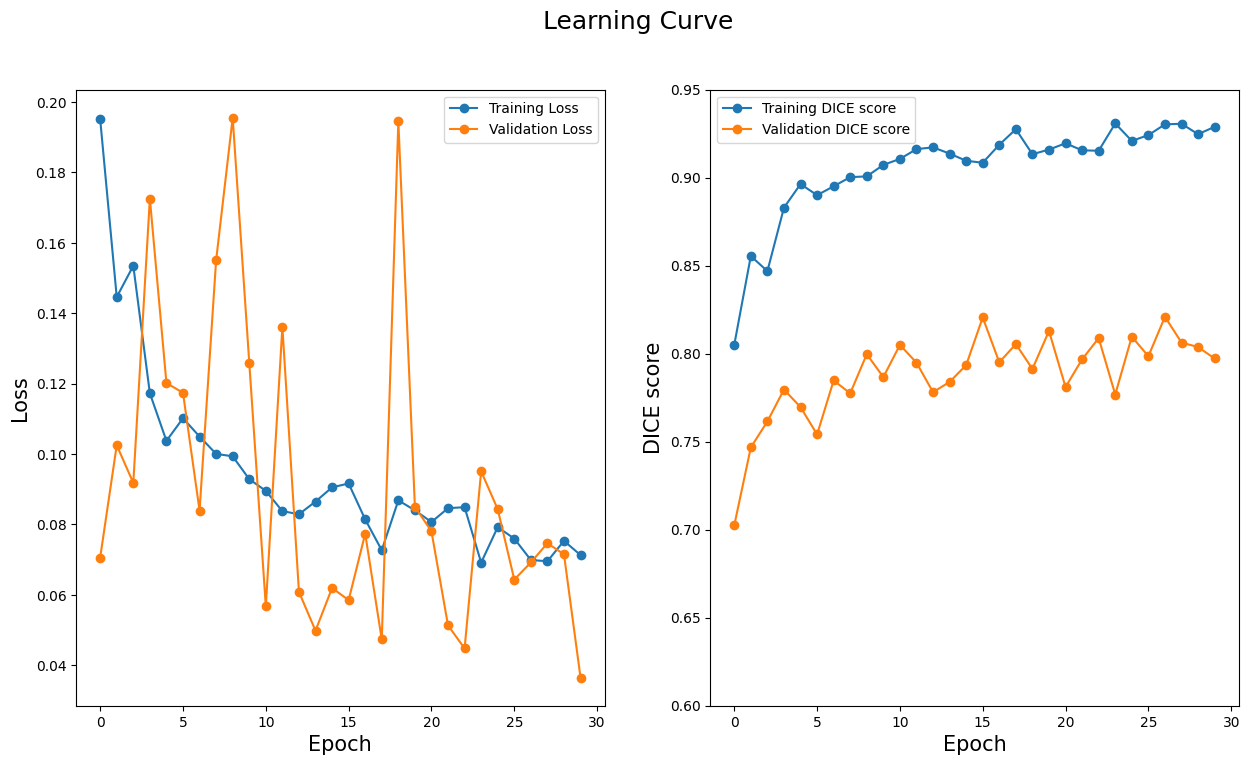

In [128]:
plot_model_history("Attention U-Net", aun_th, aun_vh, aun_lh, aun_vl, num_ep)

In [132]:
# get test DICE score 
test_iou = compute_dice(attention_unet_myocard, test_dataloader)
print(f"""Test DICE  - {test_iou}%""")

Test DICE  - 0.7958167355719236%


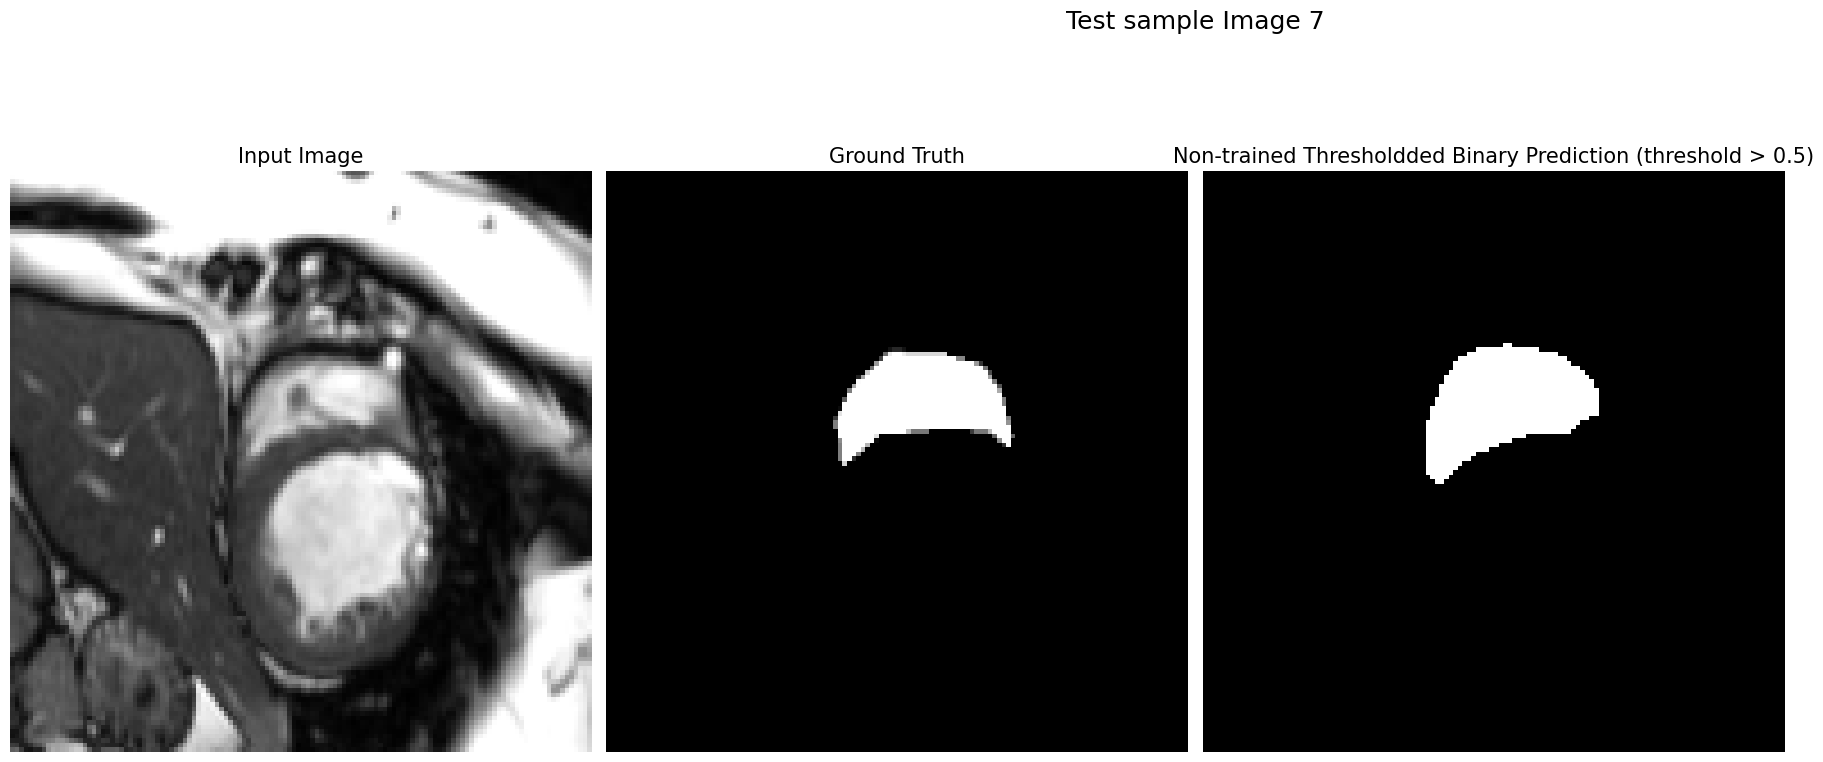

In [136]:
# Visualize model output 
batches = []

test_num = 0

for batch in test_dataloader:
    sample_batch = batch
    batches.append(batch)

sample_batch = batches[3] #0

# Generat network prediction
with torch.no_grad():
    y_pred = attention_unet_myocard(sample_batch['image'].cuda())


img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')

pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

plt.figure(figsize=(24,9))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(1,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img,cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Non-trained Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [134]:
# store output masks in array
masks_test = []
for batch in batches: 
        with torch.no_grad():
            y_pred = attention_unet_myocard(batch['image'].cuda())
        for i in range(2): 
            pred_msk = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')
            # print(pred_msk.shape)
            # print(type(pred_msk))
            masks_test.append(pred_msk)

In [135]:
output_dir_attn = Path("C:/Users/Susanna/Documents/myocardium_segmentation/outputs/attention_u_net/epicardium/masks")
contours_attn = Path("C:/Users/Susanna/Documents/myocardium_segmentation/outputs/attention_u_net/epicardium/contours")

In [209]:
#store_outputs(masks_test, output_dir_attn)

In [210]:
#store_contours(masks_test, output_dir_attn, contours_attn)